# Data Augmentation

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A
from torchvision import transforms
from torch.utils.data import Dataset

Matplotlib created a temporary cache directory at /tmp/matplotlib-2m60azvl because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from datasets import EmnistDataset, EmnistMapping, emnist_transform, FontDataset, font_transform, show_images
from config import EMNIST_TRAIN_PATH, EMNIST_TEST_PATH, EMNIST_MAPPING_PATH, FONTS_DATASET_PATH, FONTS_MAPPING_PATH

In [6]:
def print_tensor_stats(tensor, name):
    print(f"{name}: min={tensor.min().item()}, max={tensor.max().item()}, mean={tensor.mean().item()}, std={tensor.std().item()}")

## Testing augmentations

In [3]:
dataset = EmnistDataset(EMNIST_TEST_PATH, emnist_transform, limit=128)
mapping = EmnistMapping(EMNIST_MAPPING_PATH)
print("Shape:", dataset[0][0].shape)
print_tensor_stats(dataset[0][0], "EMNIST")

Shape: torch.Size([1, 28, 28])


NameError: name 'print_tensor_stats' is not defined

4


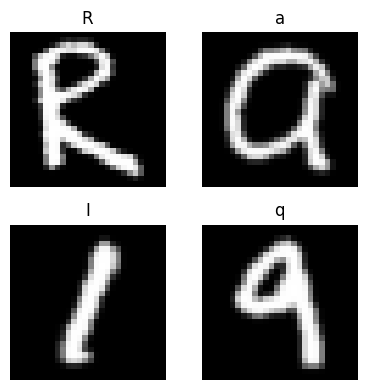

In [57]:
show_images(dataset[:4], 2, mapping.mapping)

In [565]:
class EmnistDataset(Dataset):
    def __init__(self, path, transform=None, limit=None):
        self.path = path
        self.transform = transform 
        dataset = pd.read_csv(path, header=None)
        if limit:
            dataset = dataset.sample(n=limit)
        X, y = dataset[list(range(1, dataset.shape[1]))], dataset[0]
        self.X = X.to_numpy(dtype='float32').reshape((-1, 28, 28))
        self.y = y.to_numpy()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            # Handle slicing
            images = np.expand_dims(self.X[idx], axis=3) / 255.0
            if self.transform:
                images = torch.stack([self.transform(img) for img in images])  # Apply transform per image
            labels = torch.tensor(self.y[idx], dtype=torch.long)
            return images, labels
        else:
            image = np.expand_dims(self.X[idx], axis=2) / 255.0
            if self.transform:
                image = self.transform(image)
            label = torch.tensor(self.y[idx], dtype=torch.long)
            return image, label

In [4]:
# Определение трансформаций Albumentations
albumentations_transforms = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.3),
    A.ElasticTransform(alpha=0.3, sigma=50, alpha_affine=3, p=0.2),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.GaussNoise(var_limit=(0, 0.05), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.CoarseDropout(max_holes=2, max_height=6, max_width=6, p=0.1, fill_value=0)
])

# Определение функции для применения трансформаций Albumentations
def albumentations_transform(img):
    return albumentations_transforms(image=img)['image']

# Определение трансформаций torchvision
augmentations = transforms.Compose([
    transforms.Lambda(albumentations_transform),
    transforms.ToTensor(),
    transforms.RandomRotation((-90, -90)),          # Rotate by exactly 90 degrees
    transforms.RandomHorizontalFlip(p=1),
    transforms.Normalize((0.5,), (0.5,))  # Normalizes tensor to have mean around 0 and variance around 1
])

# Применение трансформаций к изображению
# transformed_image = torchvision_transforms(image)

In [7]:
dataset = EmnistDataset(EMNIST_TEST_PATH, augmentations, limit=128)
mapping = EmnistMapping(EMNIST_MAPPING_PATH)
print("Shape:", dataset[0][0].shape)
print_tensor_stats(dataset[0][0], "EMNIST")

Shape: torch.Size([1, 28, 28])
EMNIST: min=-1.0, max=0.9940563440322876, mean=-0.6956183910369873, std=0.6019302606582642


12


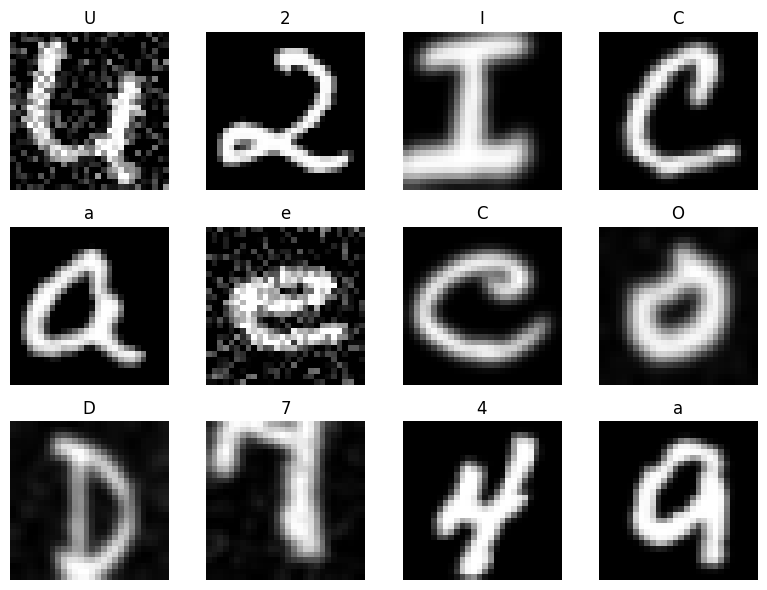

In [8]:
i = 2
show_images(dataset[12 * i: 12 * (i + 1)],3, mapping.mapping)

In [549]:
def show_image(image, mapping=None, title=None):
    # Create a figure with subplots in a grid
    fig, ax = plt.subplots(figsize=(3, 3))

    ax.imshow(image[0][0].numpy(), cmap='gray')
    ax.set_title(mapping[image[1].item()])
    ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()


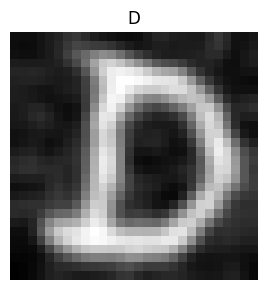

In [561]:
show_image(dataset[0], mapping.mapping)

## Testing single augmentations

In [5]:
def plot_before_after(image, after_image, operation):
    fig, axes = plt.subplots(1, 2, figsize=(4, 8))
    print(mapping[label])

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(after_image, cmap='gray')
    axes[1].set_title(operation)
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

In [6]:
transformations = {
    'rotate': A.Rotate(limit=30, p=0.99),
    'translate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.99),
    'elastic_transform': A.ElasticTransform(alpha=0.3, sigma=50, alpha_affine=3, p=0.99),
    'perspective': A.Perspective(scale=(0.05, 0.1), p=0.99),
    'affine': A.Affine(shear=(-10, 10), p=0.99),
    'gaussian_noise': A.GaussNoise(var_limit=(0, 0.1), p=0.99),
    'brightness_contrast': A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.99),
    'gaussian_blur': A.GaussianBlur(blur_limit=(3, 5), p=0.99),
    'coarse_dropout': A.CoarseDropout(max_holes=2, max_height=6, max_width=6, p=0.99, fill_value=0),
}

In [7]:
id = 55
image = dataset[id][0].numpy().transpose(1, 2, 0)
label = dataset[id][1].item()
print(image.shape)
print(label)

(28, 28, 1)
40


### All in once

rotate
perspective
coarse_dropout
J


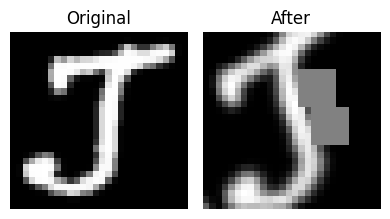

In [485]:
after_image = image
for name, augmentation in transformations.items():
    aug = augmentation(image=after_image)['image']
    if (after_image != aug).any():
        after_image = aug
        print(name)
plot_before_after(image, after_image, "After")

In [259]:
after_image.shape

(28, 28, 1)

### Just single

In [30]:
transformations = {
    'rotate': A.Rotate(limit=20, p=0.99),
    'translate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.99),
    'elastic_transform': A.ElasticTransform(alpha=0.3, sigma=50, alpha_affine=3, p=0.99),
    'perspective': A.Perspective(scale=(0.05, 0.1), p=0.99),
    'affine': A.Affine(shear=(-10, 10), p=0.99),
    'gaussian_noise': A.GaussNoise(var_limit=(0, 0.1), p=0.99),
    'brightness_contrast': A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.99),
    'gaussian_blur': A.GaussianBlur(blur_limit=(3, 5), p=0.99),
    'coarse_dropout': A.CoarseDropout(max_holes=2, max_height=6, max_width=6, p=0.99, fill_value=0),
}

f


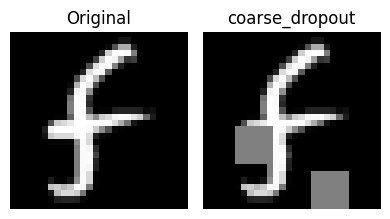

In [44]:
augmentation = 'coarse_dropout'
after_image = transformations[augmentation](image=image)['image']
plot_before_after(image, after_image, augmentation)

In [25]:
# after_image = transformations['gaussian_noise'](image=image)['image']
after_images = {}
for name, augmentation in transformations.items():
    after_images[name] = augmentation(image=image)['image']

F


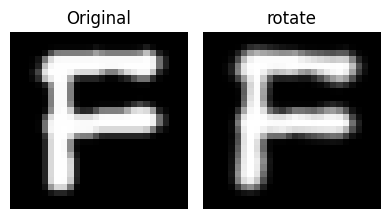

F


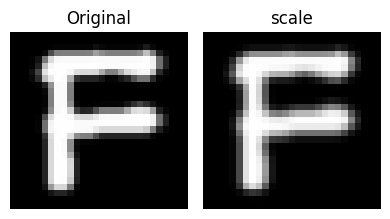

F


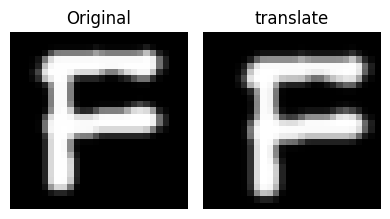

F


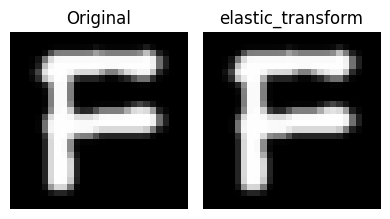

F


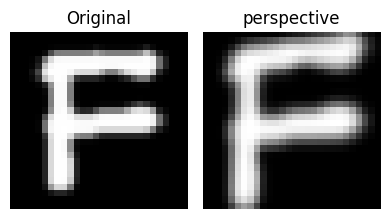

F


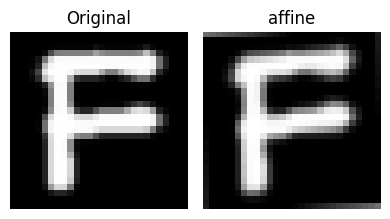

F


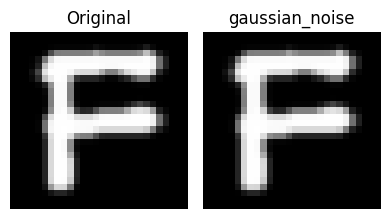

F


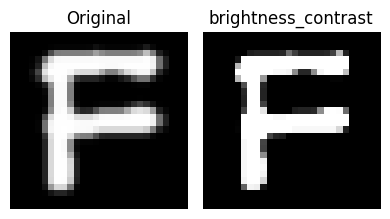

F


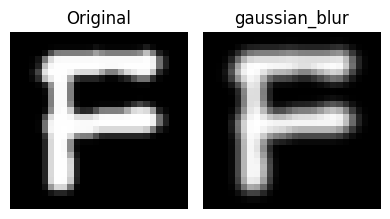

F


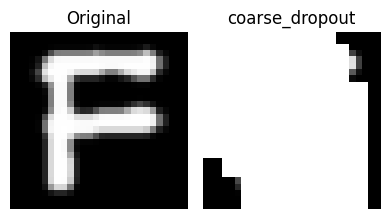

In [13]:
for augmentation, after_image in after_images.items():
    plot_before_after(image, after_image, augmentation)